# Linear Beta Pricing Models

#### Author: Gustavo Soares

## Introduction

The SDF framework gave us the so called **beta representation**:

$$
E_{t}[R^{e}_{i,t+1}] = \alpha_{i,t} + \beta_{i,t}´\lambda_{t}
$$

If markets are efficient under that particular asset pricing model, then we should have $\alpha_{i,t} = 0$. We therefore can use data to test if $\alpha_{i,t} = 0$ or not. If we find that $\alpha_{i,t} \neq 0$, then we have found an **anomaly**. However, we also discussed how we need to be careful with the interpretation of the term **anomaly** because of the **join-hypothesis problem**. The **anomaly**, $\alpha_{i,t} \neq 0$, is only evidence that the market is inefficient if our model is correct. However, under an expanded, enhanced or enriched market equilibrium model that anomaly may not be an anomaly at all and we may go back to $\alpha_{i,t} = 0$ if we use a different model.

The Capital Asset Pricing Model (CAPM) from [Sharpe (1964)](https://onlinelibrary.wiley.com/doi/full/10.1111/j.1540-6261.1964.tb02865.x) is the first and most famous asset pricing factor model. Where the $k \times 1$ random vector of time-varying factors $f_{t}$ is actually a single scalar and equal to the excess returns of the so-called **market portfolio**, $R^{M}_{t}$. In the CAPM, we also assume that the beta to the market portfolio is constant over time, i.e., $\beta_{i,t}=\beta_{i}$ and can be estimated by running a time-series regressing of the excess returns $R^{e}_{i,t+1}$ of asset $i$, or the returns of a portfolio of assets, onto the market portfolio factors $R^{M}_{t+1}$ over $t=1,\dots,T$:

$$
R^{e}_{i,t} = \alpha_{i} + \beta_{i}R^{M}_{t} + \epsilon_{i,t}
$$

Over long periods of time, we would expect that asset $i$ with high $\beta_{i}$ outperforms assets $j$ with low $\beta_{j}$.

### Fama-French style factor models

The Fama–French [three-factor model](https://www.jstor.org/stable/2329112?seq=1) and its updated [five-factor model](https://www.sciencedirect.com/science/article/abs/pii/S0304405X14002323) version was developed by nobel prize winner Eugene Fama and Kenneth French, both from University of Chicago, to describe stock returns. The idea was to extend or enrich the CAPM to take into account other characteristcs beyond the beta to the market portfolio, $R^{M}_{i,t+1}$. Specifically, the three factor model enriching the CAPM with long-short portfolios constructed based on cerrtain stock characteristics: (i) market size and (ii) the book-to-market ratio (B/P). Stocks with high B/P are called **value/cheap** stocks in contrast with **growth/expensive** stocks with low (B/P). So, the three factor model becomes:

$$
R^{e}_{i,t} = \alpha_{i} + \beta_{i}´ \begin{bmatrix}r^{M}_{t} \\ SMB_{t} \\ HML_{t}\end{bmatrix} + \eta_{i,t}
$$

where $SMB_{t}$ is the return of a long-short portfolio composed of stocks with small market capitalization on the long side and stocks with large market capitalization on the short side (called "Small Minus Big" portfolio) and $HML_{t}$ is the return of a long-short portfolio composed of stocks with with high B/M on the long side and stocks with low B/M on the short side (called "High Minus Low"). These two portfolios measure the historic excess returns of small caps over big caps and of value stocks over growth stocks. Historical values for these two portfolios can be found on [on Kenneth French's web page](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html) and the vector $\beta_{i,t}$ can be estimated by time-series regressions (assuming $\beta_{i,t}=\beta_{i}$ or using rolling regressions) as well.

Mark Carhart´s [four-factor model](https://onlinelibrary.wiley.com/doi/full/10.1111/j.1540-6261.1997.tb03808.x) is an extension of the Fama–French three-factor model including a momentum factor, the MOM factor. Momentum is the tendency for the stock price to continue rising if it is going up and to continue declining if it is going down. The $MOM_{t}$ factor is the return of a long-short portfolio composed of stocks with the highest past returns over a certain lookback period on the long side and stocks with lowest past returns over the same period.

In 2015, Fama and French extended the model to a [five-factor model](https://www.sciencedirect.com/science/article/abs/pii/S0304405X14002323), adding a further two factors profitability and investment. Defined analogously to the HML factor, the profitability factor (RMW) is the difference between the returns of firms with robust (high) and weak (low) operating profitability; and the investment factor (CMA) is the difference between the returns of firms that invest conservatively and firms that invest aggressively.

AQR´s [six-factor model](https://www.aqr.com/Insights/Perspectives/Our-Model-Goes-to-Six-and-Saves-Value-From-Redundancy-Along-the-Way) is perhaps the most used Fama-French style factor model today. Historical values for these portfolios can be found on [AQR's web page](https://www.aqr.com/Insights/Datasets).


Fama and MacBeth (1973) developed the two-pass cross-sectional regression method
to examine whether the relation between expected return and factor betas are linear.
Betas are estimated using time-series regression in the first pass, and the relation between
returns and betas is estimated using a second pass cross-sectional regression. The use of
estimated betas in the second pass introduces the well-known errors-in-variables (EIV)
problem. 

Let import a few things that will be useful when discussing how to evaluate linear beta pricing models using historical return data on a cross-section of portfolios.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader as pdr
from linearmodels.asset_pricing import TradedFactorModel, LinearFactorModel, LinearFactorModelGMM

## Fama-Macbeth Regressions

Let's use ```pandas-datareader``` to download monthly returns data from [French’s website](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html). We will grab  two data sets: (i) the 3 Fama-French factors and (ii) portfolios for 10 different industries portfolios:

In [2]:
factors = pdr.get_data_famafrench('F-F_Research_Data_Factors', start='1-1-1926')[0]
factors.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07,2.96,-2.30,-2.87,0.22
1926-08,2.64,-1.40,4.19,0.25
1926-09,0.36,-1.32,0.01,0.23
1926-10,-3.24,0.04,0.51,0.32
1926-11,2.53,-0.20,-0.35,0.31


In [3]:
industries = pdr.get_data_famafrench('10_Industry_Portfolios', start='1-1-1926')[0]
industries.head()

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Date,,,,,,,,,,
1926-07,1.45,15.55,4.69,-1.18,2.90,0.83,0.11,1.77,7.04,2.16
1926-08,3.97,3.68,2.81,3.47,2.66,2.17,-0.71,4.25,-1.69,4.38
1926-09,1.14,4.80,1.15,-3.39,-0.38,2.41,0.21,0.69,2.04,0.29
1926-10,-1.24,-8.23,-3.63,-0.78,-4.58,-0.11,-2.29,-0.57,-2.63,-2.85
1926-11,5.20,-0.19,4.10,0.01,4.71,1.63,6.43,5.42,3.71,2.11


Let's take out the risk free rate from the industry portfolios:

In [4]:
er = industries.subtract(factors.RF, axis=0)
er.head()

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Date,,,,,,,,,,
1926-07,1.23,15.33,4.47,-1.40,2.68,0.61,-0.11,1.55,6.82,1.94
1926-08,3.72,3.43,2.56,3.22,2.41,1.92,-0.96,4.00,-1.94,4.13
1926-09,0.91,4.57,0.92,-3.62,-0.61,2.18,-0.02,0.46,1.81,0.06
1926-10,-1.56,-8.55,-3.95,-1.10,-4.90,-0.43,-2.61,-0.89,-2.95,-3.17
1926-11,4.89,-0.50,3.79,-0.30,4.40,1.32,6.12,5.11,3.40,1.80


Let's now run Fama-Macbeth regressions of the type:

$$
R^{e}_{i,t} = \alpha_{i} + \beta_{i}´ \begin{bmatrix}r^{M}_{t} \\ SMB_{t} \\ HML_{t}\end{bmatrix} + \eta_{i,t} \equiv \alpha_{i} + f_{t}'\beta_{i} + \eta_{i,t}
$$

where $f_{t}$ is a $3 \times 1$ vector containing the [Fama-French (1993) factors](https://rady.ucsd.edu/faculty/directory/valkanov/pub/classes/mfe/docs/fama_french_jfe_1993.pdf): size (SMB), value (HML), and the market factor (Mkt-RF) from the CAPM model on each date $t$.

Let's estimate $\beta_{i}$ for each industry $i$ using time series regressions:

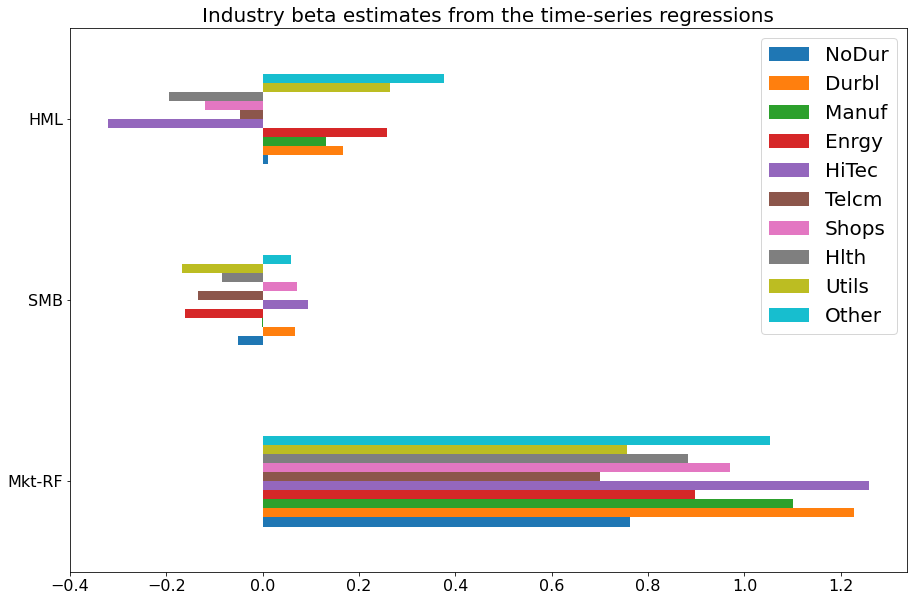

In [5]:
ff_betas = pd.DataFrame()
for i in er.columns:
    yx = pd.concat([er[[i]], factors], axis=1, sort=True).dropna()
    model = sm.OLS(yx.iloc[:,[0]], sm.add_constant(yx.iloc[:,1:-1])).fit()  
    ff_betas = ff_betas.append(model.params.to_frame(i).T)
ff_betas.iloc[:,1:].T.plot(kind='barh', figsize=(15,10), fontsize=16)
plt.title('Industry beta estimates from the time-series regressions', fontsize=20)
plt.legend(fontsize=20)
plt.show()

Let's now follow [Jagannathan, R., Skoulakis, G., & Wang, Z. (2010)](https://www.scholars.northwestern.edu/en/publications/the-analysis-of-the-cross-section-of-security-returns) and rewrite our regression in vector format:

$$
R^{e}_{t} = \alpha + \beta f_{t} + \eta_{t}
$$

where $\beta$ is the $N \times K$ matrix of factor betas for each of the $K=3$ factors and $N=10$ industries. Analogously, $R^{e}_{t}$ are $N \times 1$ vectors of $N$ returns on date $t$ and $\alpha$ is the $N \times 1$ vector of alphas. 

Now, let's define $\hat{\Sigma}_{F}$ as the $K \times K$ covariance matrix of the FF factors:

$$
\hat{\Sigma}_{F} \equiv T^{-1}\sum_{t}(f_{t}-\bar{f})(f_{t}-\bar{f})' \equiv \\ T^{-1}\sum_{t} \begin{bmatrix}r^{M}_{t} - \bar{r}^{M}\\ SMB_{t} - \bar{SMB}\\ HML_{t}-\bar{HML}\end{bmatrix} \begin{bmatrix}r^{M}_{t} - \bar{r}^{M} & SMB_{t} - \bar{SMB} & HML_{t}-\bar{HML}\end{bmatrix}
$$

where $\bar{f} = T^{-1}\sum_{t}f_{t}$.

Then, in the first-stage, we estimated $\beta$ using OLS as:

$$
\hat{\beta} \equiv \hat{\Sigma}_{RF}\hat{\Sigma}_{F}^{-1}
$$

where

$$
\hat{\Sigma}_{RF} \equiv T^{-1}\sum_{t} (R^{e}_{t} - \bar{R}^{e})(f_{t}-\bar{f})'.
$$

Going back to the **beta representation**, $E[R^{e}_{t}] = \alpha \iota_{N} + \beta´\lambda$, the estimate for the $K \times 1$ vector of risk premia, $\lambda$, and the scalar $\alpha$ becomes:

$$
\hat{c} \equiv \begin{bmatrix}\hat{\alpha} \\ \hat{\lambda}\end{bmatrix} \equiv (X(\hat\beta)'X(\hat\beta))^{-1}X(\hat\beta)'\bar{R}^{e}
$$

where $X(\hat\beta)$ is the $N \times (K+1)$ matrix:$X(\hat\beta) \equiv \begin{bmatrix}\iota_{N} & \hat{\beta} \end{bmatrix}$.

Let's try estimating $\hat{\alpha}$ and $\hat{\lambda}$ that way, by regressing average returns on $X(\hat\beta)$: 

This is the estimate for alpha (annualized):3.11
These are the estimates for the vector of risk premia:
Mkt-RF    0.502964
SMB      -0.247652
HML      -0.202230
dtype: float64


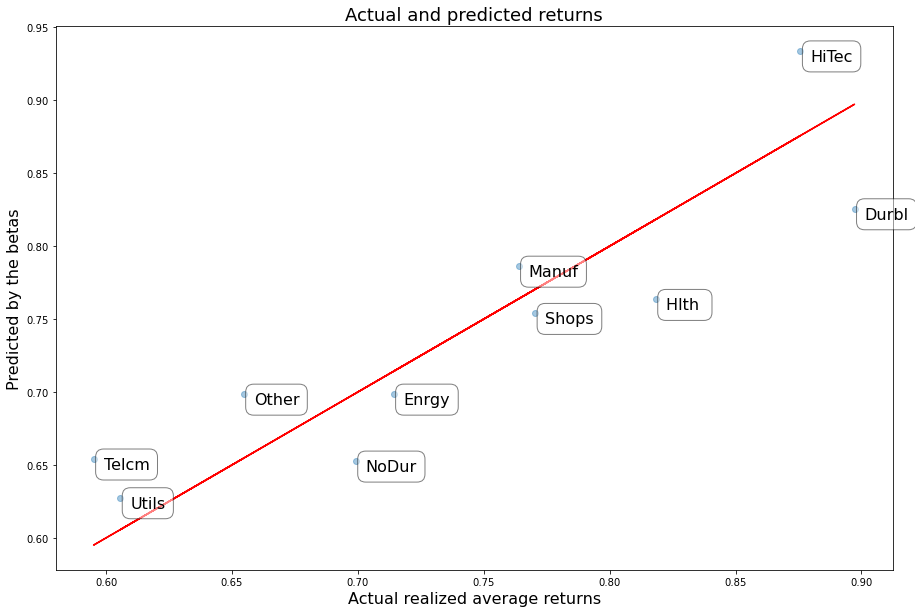

In [6]:
model = sm.OLS(er.mean(), sm.add_constant(ff_betas.iloc[:,1:])).fit()  
print(f'This is the estimate for alpha (annualized):{np.round(12 * model.params[0],2)}')
print('These are the estimates for the vector of risk premia:')
print(model.params[1:])

x = er.mean().values
y = model.predict(sm.add_constant(ff_betas.iloc[:,1:]))
plt.figure(figsize=(15, 10))
plt.scatter(x, y, cmap=plt.get_cmap('RdBu'), alpha=0.4)
plt.plot(x, x, color='r')
plt.title('Actual and predicted returns', fontsize=18)
plt.ylabel('Predicted by the betas', fontsize=16)
plt.xlabel('Actual realized average returns', fontsize=16)

for i in range(x.shape[0]):
    plt.annotate(er.columns[i], xy=(x[i], y[i]),
                 xytext=(10, -10), textcoords='offset points', size=16,
                 bbox=dict(boxstyle='round,pad=0.5', fc='white',
                           alpha=0.5))

plt.show()

## The errors-in-variable (EIV) problem

To conduct inference, build confidence intervals and test the, we need an estimates of the asymptotic covariance of the estimator $\hat{c}$. Originally, Fama and MacBeth (1973) proposed using:

$$
T^{-1}\sum_{t} (c_{t} - \bar{c})(c_{t} - \bar{c})'. 
$$

where $\hat{c}_{t} \equiv (X(\hat\beta)'X(\hat\beta))^{-1}X(\hat\beta)'R^{e}_{t}$ and $\bar{c} = T^{-1}\sum_{t}c_{t}$.

However, the Fama–MacBeth estimator ignores the estimation error present in $\hat\beta$ and suffers from the so-called errors-in-variable (EIV) problem. In addition, it does not account for the returns and factors potentially being serially correlated.

## Feasible GLS

Feasible GLS is normally used nowadays since the Fama–MacBeth estimator ignores the estimation error in betas as well as potential serial correlation in returns. So, instead, we estimate:

$$
\hat{c} \equiv \begin{bmatrix}\hat{\alpha} \\ \hat{\lambda}\end{bmatrix} \equiv (X(\hat\beta)'\hat{W}X(\hat\beta))^{-1}X(\hat\beta)'\hat{W}\bar{R}^{e}
$$

where $\hat{W}$ is a $N \times N$ matrix of weights which converges in probability to some $N \times N$ matrix $W$. We have a few options for $\hat{W}$.

Because our factors here are actual returns, as opposed to asset features or characteristics, we can use Kevin Sheppard's [```linearmodels.asset_pricing.model.TradedFactorModel``` ](https://bashtage.github.io/linearmodels/asset-pricing/asset-pricing/linearmodels.asset_pricing.model.TradedFactorModel.html#linearmodels.asset_pricing.model.TradedFactorModel) which uses the covariance of the risk premia estimates based on the factor residuals:

In [7]:
mod = TradedFactorModel(er, factors.iloc[:,:-1])
res = mod.fit(cov_type="kernel")
print(res.full_summary)

                      TradedFactorModel Estimation Summary                      
No. Test Portfolios:                 10   R-squared:                      0.7609
No. Factors:                          3   J-statistic:                    39.759
No. Observations:                  1137   P-value                         0.0000
Date:                  Mon, May 10 2021   Distribution:                 chi2(10)
Time:                          21:19:42                                         
Cov. Estimator:                  kernel                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF         0.6848     0.1681     4.0735     0.0000      0.3553      1.0143
SMB            0.2077     0.1004    

## Generalized Methods of Moments (GMM)

### 2-steps GMM

Kevin Sheppard's [```linearmodels.asset_pricing.model.TradedFactorModel```](https://bashtage.github.io/linearmodels/asset-pricing/asset-pricing/linearmodels.asset_pricing.model.TradedFactorModel.html#linearmodels.asset_pricing.model.TradedFactorModel) only applies in the case that the factors are portfolios themselves.

However, when one of more factors are not returns on traded assets, we can still use the two step procedure we outlined above. In the first step, we estimate factor loadings by regressing the excess returns on the factors (augmented with a constant). In the second step, we use the factor loadings to estimate the risk premia with the dependent variable is the average excess return.

Because of the EIV problem, we need to be careful when performing inference. So, let's use Kevin Sheppard's [```linearmodels v4.24linearmodels.asset_pricing.model.TradedFactorModel```](https://bashtage.github.io/linearmodels/asset-pricing/asset-pricing/linearmodels.asset_pricing.model.LinearFactorModel.html#linearmodels.asset_pricing.model.LinearFactorModel):

In [8]:
mod = LinearFactorModel(er, factors.iloc[:,:-1])
res = mod.fit(cov_type="kernel")
print(res.full_summary)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 10   R-squared:                      0.7609
No. Factors:                          3   J-statistic:                    2.8130
No. Observations:                  1137   P-value                         0.9017
Date:                  Mon, May 10 2021   Distribution:                  chi2(7)
Time:                          21:19:42                                         
Cov. Estimator:                  kernel                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF         0.7571     0.1683     4.4986     0.0000      0.4272      1.0869
SMB           -0.6689     0.4124    

### Single-step GMM

The GMM estimator does not need to be carried out in 2-steps, it can be estimated in a single step. Let's use Kevin Sheppard's [```	
linearmodels v4.24linearmodels.asset_pricing.model.LinearFactorModelGMM```](https://bashtage.github.io/linearmodels/asset-pricing/asset-pricing/linearmodels.asset_pricing.model.LinearFactorModelGMM.html#linearmodels.asset_pricing.model.LinearFactorModelGMM). In his procedure, progress of the optimizer is printed every 10 iterations and the model is fit twice, which is the standard method to implement efficient GMM, once to get an consistent estimate of the covariance of the moment conditions and the second time to efficiently estimate parameters.

In [9]:
mod = LinearFactorModelGMM(er, factors.iloc[:,:-1])
res = mod.fit(cov_type="kernel")
print(res.full_summary)

Iteration: 0, Objective: 4.45949071697708
Iteration: 10, Objective: 3.3301447582430646
Iteration: 20, Objective: 3.189358473124468
Iteration: 30, Objective: 3.1273567335969092
Iteration: 40, Objective: 3.0156901748599405
         Current function value: 3.015690
         Iterations: 42
         Function evaluations: 4008
         Gradient evaluations: 108
Iteration: 0, Objective: 3.091101739321888
Iteration: 10, Objective: 3.0817527148664077
Iteration: 20, Objective: 3.0800701092669533
Iteration: 30, Objective: 3.0791222589419074
Iteration: 40, Objective: 3.075819481887868
Optimization terminated successfully.
         Current function value: 3.075819
         Iterations: 41
         Function evaluations: 1739
         Gradient evaluations: 47
                    LinearFactorModelGMM Estimation Summary                     
No. Test Portfolios:                 10   R-squared:                      0.7608
No. Factors:                          3   J-statistic:                    3.0758
No.